In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import matplotlib
from scipy.stats import describe
from scipy.signal import savgol_filter
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
import autosklearn.classification
from collections import Counter
import phase_model as pm
from phase_features_loader import PhaseFeaturesLoader
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix

/home/cahya/.virtualenvs/phase/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset_train_big = "data/phase/ml_features.csv"
dataset_train_tiny = "data/phase/ml_features_tiny.csv"
dataset_train = "data/phase/ml_features_train.csv"
dataset_test = "data/phase/ml_features_test.csv"
dataset_train_relabeled = "data/phase/ml_features_train_relabeled.csv"
dataset_test_relabeled = "data/phase/ml_features_test_relabeled.csv"
STA = "URZ"
phases = ["regP", "regS", "tele", "N"]

In [4]:
dff = pd.read_csv(filepath_or_buffer=dataset_train_tiny)
dff.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,1582602,LPAZ,9.482724e+08,Lg,regS,Lg,regP,0.000000,M,0.666667,...,1.815760,0.281515,4.312000,0.0,-0.360000,0.672331,2.462823,1.196801,1.564852,0.810008
1,3392748,LPAZ,9.660487e+08,Sn,regS,Lg,regP,2.250001,M,0.333333,...,3.318087,5.777322,3.312782,0.0,0.000000,0.771338,0.658481,2.513435,3.555231,1.341278
2,4251736,LPAZ,9.755992e+08,Lg,regS,Lg,regP,0.549998,M,0.289855,...,5.006600,3.991400,1.593971,-0.1,-0.215000,1.842368,6.353942,0.422784,1.290310,1.712811
3,5843204,LPAZ,9.915611e+08,Lg,regS,Sn,regP,2.170612,M,0.571429,...,2.034370,4.254982,4.254982,0.0,0.000000,1.255465,2.631712,1.016241,2.840468,9.503727
4,6033158,LPAZ,9.934632e+08,Sn,regS,Sn,regP,2.549999,M,0.166667,...,1.822586,1.937456,4.009178,-0.3,-0.453333,0.410712,1.057677,0.842994,1.624028,1.184967


In [5]:
x_indices = ['INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5',
                              'PER', 'RECT', 'PLANS', 'NAB', 'TAB', 'TIME', 'ARID']
phase_length_all = {"URZ": {"regP": 10000, "regS": 10000, "tele": 50000, "N": 500000}}
validation_split = 0.1
batch_size = 1024
# load train dataset
pd_train_all = PhaseFeaturesLoader(filename=dataset_train, validation_split=validation_split, x_indices = x_indices,
                         phase_length=phase_length_all, batch_size=batch_size)

x_train_all, y_train_all = pd_train_all.get_dataset(expand_dim=False, y_onehot=False)

length regP:7151
length regS:6853
length tele:29232
length N:294531


In [6]:
p_counter = [[], [], [], []]
items = sorted(Counter(y_train_all).items())
p_counter = [np.zeros(24*60, dtype="int") for i in phases]
for i, x in enumerate(x_train_all):
    t = int(x_train_all[i, 15])
    try:
        p_counter[y_train_all[i]][t] += 1
    except IndexError:
        print(i, x)

print(np.sum(p_counter))

337767


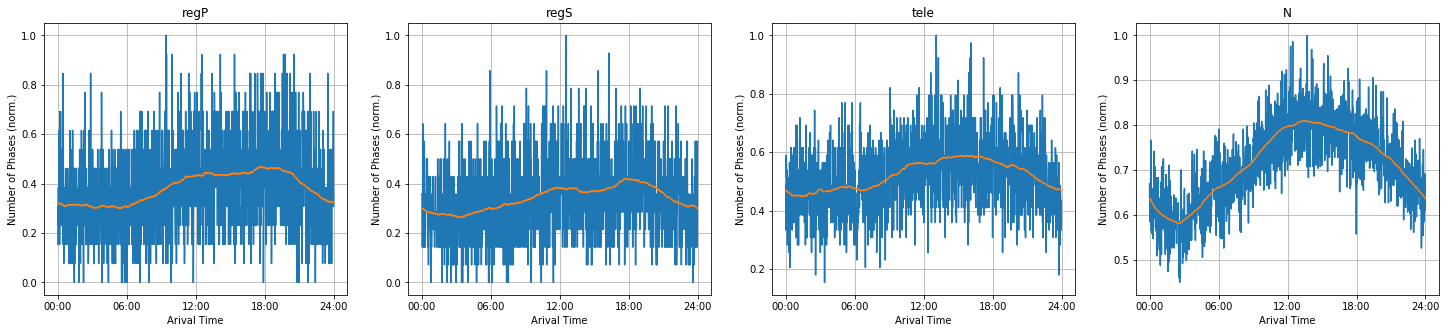

In [7]:
plt.figure(1, figsize=(25, 5))
for i, p in enumerate(phases):
    p_norm = p_counter[i]/describe(p_counter[i]).minmax[1]
    #print(describe(p_counter[i]))
    #print(describe(p_norm))
    ax = plt.subplot(1, 4, i+1)
    yhat = savgol_filter(p_norm, 401, 3, mode="wrap")
    plt.title(p)
    plt.xticks(np.arange(0, 25*60, 60*6), ("00:00", "06:00", "12:00", "18:00", "24:00"))
    plt.xlabel("Arival Time")
    plt.ylabel("Number of Phases (norm.)")
    plt.plot(p_norm)   
    plt.plot(yhat)
    plt.grid(True)
plt.show()

In [8]:
# load train dataset
x_indices = ['INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5',
                              'PER', 'RECT', 'PLANS', 'NAB', 'TAB', 'SLOW']
validation_split = 0.1
batch_size = 1024
phase_length = {"URZ": {"regP": 6840, "regS": 6840, "tele": 6840, "N": 6840*3}}
pd_train = PhaseFeaturesLoader(filename=dataset_train, validation_split=validation_split,
                               phase_length=phase_length, batch_size=batch_size, x_indices=x_indices)

x_train, y_train = pd_train.get_dataset(expand_dim=False, y_onehot=False)

length regP:6840
length regS:6840
length tele:6840
length N:20520


In [9]:
# load test dataset
x_indices = ['INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5',
                              'PER', 'RECT', 'PLANS', 'NAB', 'TAB', 'SLOW']
phase_length = {"URZ": {"regP": 2280, "regS": 2280, "tele": 2280, "N": 2280*3}}
pd_test = PhaseFeaturesLoader(filename=dataset_test, phase_length=phase_length, 
                              batch_size=batch_size, x_indices=x_indices)
x_test, y_test = pd_test.get_dataset(expand_dim=False, y_onehot=False)
print(pd_test.get_phase_index(100089180))

length regP:2280
length regS:2280
length tele:2280
length N:6840
0


In [10]:
classifiers = ["NN", "SVM", "XGBoost", "GCForest", "AutoML"]
#classifiers = ["NN"]
classifier_index = {classifier: i for i, classifier in enumerate(classifiers)}
functions = globals().copy()
classifier_class = {c: getattr(sys.modules["phase_model"], c) for c in classifiers}
print(classifier_class)
print(classifier_index)

{'SVM': <class 'phase_model.SVM'>, 'NN': <class 'phase_model.NN'>, 'XGBoost': <class 'phase_model.XGBoost'>, 'AutoML': <class 'phase_model.AutoML'>, 'GCForest': <class 'phase_model.GCForest'>}
{'SVM': 1, 'NN': 0, 'XGBoost': 2, 'AutoML': 4, 'GCForest': 3}


In [11]:
def run_model_train_predict_all():
    for name in classifiers:
        print(classifier_class[name])
        model = classifier_class[name]()
        sampling_type="nosampling"
        print("model:", model)
        time_start = time.time()
        model.fit(x_train, y_train, verbose=0, sampling_type=sampling_type)
        time_end = time.time()
        print("Training time: {} seconds".format(time_end - time_start))
        model.save("results/phase_train_{}_{}.mdl".format(model.class_name().lower(), sampling_type))
        model.predict(x_test, y_test, sampling_type=sampling_type)

run_model_train_predict_all()

<class 'phase_model.NN'>
model: <phase_model.NN object at 0x7fc1f7580860>
Before resampling: [(0, 6840), (1, 6840), (2, 6840), (3, 20520)]
After resampling: [(0, 6840), (1, 6840), (2, 6840), (3, 20520)]
Max of acc: 0.7613980939875233, val_acc: 0.767056530214425
Min of loss: 0.6005314568407432, val_loss: 0.5901070321977254
Before resampling: [(0, 2280), (1, 2280), (2, 2280), (3, 6840)]
After resampling: [(0, 2280), (1, 2280), (2, 2280), (3, 6840)]
Accuracy: 76.68128654970761
<class 'phase_model.SVM'>
model: <phase_model.SVM object at 0x7fc1e8a4bb00>
Before resampling: [(0, 6840), (1, 6840), (2, 6840), (3, 20520)]
After resampling: [(0, 6840), (1, 6840), (2, 6840), (3, 20520)]
GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True,

[INFO] [19:06:55:gcforest.cascade.cascade_classifier] X_groups_train.shape=[(41040, 16)],y_train.shape=(41040,),X_groups_test.shape=no_test,y_test.shape=no_test
[INFO] [19:06:55:gcforest.cascade.cascade_classifier] group_dims=[16]
[INFO] [19:06:55:gcforest.cascade.cascade_classifier] group_starts=[0]
[INFO] [19:06:55:gcforest.cascade.cascade_classifier] group_ends=[16]
[INFO] [19:06:55:gcforest.cascade.cascade_classifier] X_train.shape=(41040, 16),X_test.shape=(0, 16)
[INFO] [19:06:55:gcforest.cascade.cascade_classifier] [layer=0] look_indexs=[0], X_cur_train.shape=(41040, 16), X_cur_test.shape=(0, 16)


After resampling: [(0, 6840), (1, 6840), (2, 6840), (3, 20520)]


[INFO] [19:06:56:gcforest.estimators.kfold_wrapper] Accuracy(layer_0 - estimator_0 - 5_folds.train_0.predict)=74.71%
[INFO] [19:06:56:gcforest.estimators.kfold_wrapper] Accuracy(layer_0 - estimator_0 - 5_folds.train_1.predict)=74.55%
[INFO] [19:06:56:gcforest.estimators.kfold_wrapper] Accuracy(layer_0 - estimator_0 - 5_folds.train_2.predict)=73.79%
[INFO] [19:06:57:gcforest.estimators.kfold_wrapper] Accuracy(layer_0 - estimator_0 - 5_folds.train_3.predict)=74.61%
[INFO] [19:06:57:gcforest.estimators.kfold_wrapper] Accuracy(layer_0 - estimator_0 - 5_folds.train_4.predict)=74.63%
[INFO] [19:06:57:gcforest.estimators.kfold_wrapper] Accuracy(layer_0 - estimator_0 - 5_folds.train_cv.predict)=74.46%
[INFO] [19:06:58:gcforest.estimators.kfold_wrapper] Accuracy(layer_0 - estimator_1 - 5_folds.train_0.predict)=74.24%
[INFO] [19:07:00:gcforest.estimators.kfold_wrapper] Accuracy(layer_0 - estimator_1 - 5_folds.train_1.predict)=73.15%
[INFO] [19:07:01:gcforest.estimators.kfold_wrapper] Accuracy(la

[INFO] [19:08:01:gcforest.estimators.kfold_wrapper] Accuracy(layer_2 - estimator_3 - 5_folds.train_0.predict)=77.22%
[INFO] [19:08:04:gcforest.estimators.kfold_wrapper] Accuracy(layer_2 - estimator_3 - 5_folds.train_1.predict)=76.79%
[INFO] [19:08:07:gcforest.estimators.kfold_wrapper] Accuracy(layer_2 - estimator_3 - 5_folds.train_2.predict)=76.02%
[INFO] [19:08:10:gcforest.estimators.kfold_wrapper] Accuracy(layer_2 - estimator_3 - 5_folds.train_3.predict)=76.73%
[INFO] [19:08:13:gcforest.estimators.kfold_wrapper] Accuracy(layer_2 - estimator_3 - 5_folds.train_4.predict)=76.55%
[INFO] [19:08:13:gcforest.estimators.kfold_wrapper] Accuracy(layer_2 - estimator_3 - 5_folds.train_cv.predict)=76.66%
[INFO] [19:08:13:gcforest.cascade.cascade_classifier] Accuracy(layer_2 - train.classifier_average)=76.60%
[INFO] [19:08:13:gcforest.cascade.cascade_classifier] [layer=3] look_indexs=[0], X_cur_train.shape=(41040, 32), X_cur_test.shape=(0, 32)
[INFO] [19:08:14:gcforest.estimators.kfold_wrapper] Ac

[INFO] [19:09:26:gcforest.estimators.kfold_wrapper] Accuracy(layer_5 - estimator_1 - 5_folds.train_4.predict)=76.84%
[INFO] [19:09:26:gcforest.estimators.kfold_wrapper] Accuracy(layer_5 - estimator_1 - 5_folds.train_cv.predict)=76.67%
[INFO] [19:09:27:gcforest.estimators.kfold_wrapper] Accuracy(layer_5 - estimator_2 - 5_folds.train_0.predict)=76.08%
[INFO] [19:09:27:gcforest.estimators.kfold_wrapper] Accuracy(layer_5 - estimator_2 - 5_folds.train_1.predict)=74.94%
[INFO] [19:09:27:gcforest.estimators.kfold_wrapper] Accuracy(layer_5 - estimator_2 - 5_folds.train_2.predict)=73.87%
[INFO] [19:09:27:gcforest.estimators.kfold_wrapper] Accuracy(layer_5 - estimator_2 - 5_folds.train_3.predict)=74.66%
[INFO] [19:09:28:gcforest.estimators.kfold_wrapper] Accuracy(layer_5 - estimator_2 - 5_folds.train_4.predict)=74.67%
[INFO] [19:09:28:gcforest.estimators.kfold_wrapper] Accuracy(layer_5 - estimator_2 - 5_folds.train_cv.predict)=74.84%
[INFO] [19:09:31:gcforest.estimators.kfold_wrapper] Accuracy(l

[INFO] [19:10:45:gcforest.estimators.kfold_wrapper] Accuracy(layer_8 - estimator_0 - 5_folds.train_2.predict)=74.50%
[INFO] [19:10:45:gcforest.estimators.kfold_wrapper] Accuracy(layer_8 - estimator_0 - 5_folds.train_3.predict)=74.99%
[INFO] [19:10:45:gcforest.estimators.kfold_wrapper] Accuracy(layer_8 - estimator_0 - 5_folds.train_4.predict)=74.94%
[INFO] [19:10:45:gcforest.estimators.kfold_wrapper] Accuracy(layer_8 - estimator_0 - 5_folds.train_cv.predict)=74.81%
[INFO] [19:10:48:gcforest.estimators.kfold_wrapper] Accuracy(layer_8 - estimator_1 - 5_folds.train_0.predict)=75.76%
[INFO] [19:10:50:gcforest.estimators.kfold_wrapper] Accuracy(layer_8 - estimator_1 - 5_folds.train_1.predict)=76.77%
[INFO] [19:10:52:gcforest.estimators.kfold_wrapper] Accuracy(layer_8 - estimator_1 - 5_folds.train_2.predict)=76.29%
[INFO] [19:10:55:gcforest.estimators.kfold_wrapper] Accuracy(layer_8 - estimator_1 - 5_folds.train_3.predict)=77.36%
[INFO] [19:10:57:gcforest.estimators.kfold_wrapper] Accuracy(la

Before resampling: [(0, 2280), (1, 2280), (2, 2280), (3, 6840)]
After resampling: [(0, 2280), (1, 2280), (2, 2280), (3, 6840)]


[INFO] [19:11:16:gcforest.cascade.cascade_classifier] [layer=1] look_indexs=[0], X_cur_test.shape=(13680, 32)
[INFO] [19:11:17:gcforest.cascade.cascade_classifier] [layer=2] look_indexs=[0], X_cur_test.shape=(13680, 32)
[INFO] [19:11:18:gcforest.cascade.cascade_classifier] [layer=3] look_indexs=[0], X_cur_test.shape=(13680, 32)
[INFO] [19:11:20:gcforest.cascade.cascade_classifier] [layer=4] look_indexs=[0], X_cur_test.shape=(13680, 32)
[INFO] [19:11:21:gcforest.cascade.cascade_classifier] [layer=5] look_indexs=[0], X_cur_test.shape=(13680, 32)
[INFO] [19:11:22:gcforest.cascade.cascade_classifier] X_groups_test.shape=[(13680, 16)]
[INFO] [19:11:22:gcforest.cascade.cascade_classifier] group_dims=[16]
[INFO] [19:11:22:gcforest.cascade.cascade_classifier] X_test.shape=(13680, 16)
[INFO] [19:11:22:gcforest.cascade.cascade_classifier] [layer=0] look_indexs=[0], X_cur_test.shape=(13680, 16)
[INFO] [19:11:23:gcforest.cascade.cascade_classifier] [layer=1] look_indexs=[0], X_cur_test.shape=(1368

Accuracy: 77.10%
<class 'phase_model.AutoML'>
model: <phase_model.AutoML object at 0x7fc1e8970d68>
Before resampling: [(0, 6840), (1, 6840), (2, 6840), (3, 20520)]
After resampling: [(0, 6840), (1, 6840), (2, 6840), (3, 20520)]
AutoSklearnClassifier(delete_output_folder_after_terminate=True,
           delete_tmp_folder_after_terminate=True,
           disable_evaluator_output=False, ensemble_nbest=50,
           ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25,
           ml_memory_limit=3072, output_folder=None,
           per_run_time_limit=360, resampling_strategy='holdout',
           resampling_strategy_arguments=None, seed=1, shared_mode=False,
           smac_scenario_args=None, time_left_for_this_task=3600,
           tmp_folder=None)
[WARNING] [2018-05-07 19:11:30,411:smac.intensification.intensif